# **Fine-tuning CLIP for Visual Grounding tasks**

*Abstract*

Visual Grounding is a challenging task which aims to locate an object in an image based on a natural language query. Despite impressive advances in computer vision and natural language processing, relating different parts of image and text to achieve a good comprehension of context is still a big research area. In our work, we explored some ways to solve the problem by exploiting the image-text alignment already present in Clip as a foundation model for new frameworks specialized in Visual Grounding.

\
*Introduction*

First, we propose a baseline that combines the object detector Yolo [1] and CLIP [2] model without any other component. For each candidate object proposed by Yolo is computed a cosine similarity with the text query and the most similar one is chosen as output prediction. We then tried to break free from the object detector developing a framework based on heatmaps [3] to retrieve the target object and on SAM [4] to draw a proper bounding box. We finally developed a new framework obtained by customizing the CLIP model to compute a low-level probability map from which we find a bounding box through some up-sampling convolutions [5]. Fine-tuning allowed us to leverage Clip strengths without the need for heavy training, therefore beyond the results, it seems to be the most promising direction.

\

*Related work*

- Visual Grounding
- Reffering Image Segmentation
- Adapters and Fine-tuning


<!-- The recent development of new and promising models and methods has lead to a surprising advancement and spread of deep learning frameworks in many areas. Nevertheless, many issues are still far from being fully solved and a lot of researchers are still working on them.\
Visual Grounding is one of this complex task: it consists in retrievial an object in a image based on a text description. To solve the problem, a model has not only to have a deep comprehension of both image and text, but also to be able to relate effectively local and global context.\
Our system try to achieve this aim exploiting the image text allignement already present in Clip and fine-tuning it to adapt to the new objective.

\
In this paper, we propose a transformer based approach for
visual grounding. Unlike existing proposal-and-rank frameworks that rely heavily on pretrained object detectors or
proposal-free frameworks that upgrade an off-the-shelf onestage detector by fusing textual embeddings, our approach
is built on top of a transformer encoder-decoder and is independent of any pretrained detectors or word embedding models. Termed as VGTR – Visual Grounding with TRansformers, our approach is designed to learn semantic-discriminative
visual features under the guidance of the textual description
without harming their location ability. This information flow
enables our VGTR to have a strong capability in capturing
context-level semantics of both vision and language modalities, rendering us to aggregate accurate visual clues implied
by the description to locate the interested object instance. Experiments show that our method outperforms state-of-the-art
proposal-free approaches by a considerable margin on four
benchmarks.

\
Recent advances in computer vision and natural language processing have naturally
led to active research in multi-modal tasks, including Referring Image Segmentation (RIS). Recent approaches have advanced the frontier of RIS by impressive
margins, but they require an additional pretraining stage on external visual grounding datasets to achieve the state-of-the-art performances. We attempt to break free
from this requirement by effectively adapting Contrastive Language-Image Pretraining (CLIP) to RIS. We propose a novel framework that residually adapts frozen
CLIP features to RIS with Fusion Adapters and Backbone Adapters. Freezing CLIP
preserves the backbone’s rich, general image-text alignment knowledge, whilst
Fusion Adapters introduce multi-modal communication and Backbone Adapters
inject new knowledge useful in solving RIS. Our method reaches a new state of the
art on three major RIS benchmarks. We attain such performance without additional
pretraining and thereby absolve the necessity of extra training and data preparation.
Source code and model weights will be available upon publication -->

# Baseline

In this section, we implemented a baseline using Yolo and CLIP. We process one image at a time and use Yolo to detect all relevant objects in the image. We then use the CLIP visual encoder to encode each candidate and the text encoder to encode the text query. Finally, we compute a cosine similarity between the encodings of each object and the text query. In case of more sentences, we compute the average of the similarities for each one. We consider as output the object with the higher similarity.


### Things to install

In [1]:
# download CLIP
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

# download and unzip RefCOCOg dataset
!gdown 1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq
!tar -xf /content/refcocog.tar.gz

# download Yolo
!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.4 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-hie1j3rh
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-hie1j3rh
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369499 sha256=2a50fe4df79997e7c2b04c80596e4eb9705546c4423874bb131532e122f8635d
  Stored in directory: /tmp/pip-ephem-wheel-cache-_t5v5exu/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
Downloading...
From: https://drive.google.com/uc?id=1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq
To: /content/refcocog.tar.gz
100% 13.5G/13.5G [02:16<00:00, 98.7MB/s]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 609.5/609.5

### Baseline Dataset

In [3]:
import json
import clip
import torch
import pandas
import numpy as np

from torch.utils.data import Dataset, DataLoader
from typing import Sequence, Union

from PIL import Image, ImageDraw



class RefcocogDataset(Dataset):
    """  Custom dataset class for RefCOCOg dataset """

    def __init__(self, base_path, split=None, transform=None, tokenization=None):
        annotation_path = base_path + "/annotations/"

        self.IMAGES_PATH = base_path + "/images/"
        self.transform = transform
        self.tokenization = tokenization

        tmp_annotations = pandas.read_pickle(annotation_path + "refs(umd).p")
        tmp_instances = json.load(open(annotation_path + "instances.json", "r"))

        annotations_dt = pandas.DataFrame.from_records(tmp_annotations) \
            .filter(items=["image_id", "split", "sentences", "ann_id"])

        instances_dt = pandas.DataFrame.from_records(tmp_instances['annotations'])

        self.annotations = annotations_dt \
            .merge(instances_dt[["id", "bbox", "area"]], left_on="ann_id", right_on="id") \
            .drop(columns="id")

        if split is not None:
            self.annotations = self.__get_annotations_by_split(split.lower())

    def getImage(self, sample):
        id = sample['idx'][0].item()
        item = self.annotations.iloc[id]
        image = self.__getimage(item.image_id)

        return image

    def getSentences(self, sample):
        id = sample['idx'][0].item()
        item = self.annotations.iloc[id]

        return self.__extract_sentences(item.sentences)

    def showImage(self, train_features, train_bbox):
        img = self.getImage(train_features)
        img1 = ImageDraw.Draw(img)
        img1.rectangle([(train_bbox[0].item(), train_bbox[1].item()), (train_bbox[0].item()+train_bbox[2].item(), train_bbox[1].item()+train_bbox[3].item())], outline ="red")
        img.show()

    def __get_annotations_by_split(self, split):
        return self.annotations[self.annotations.split == split].reset_index()

    def __getimage(self, id):
        return Image.open(self.IMAGES_PATH + "COCO_train2014_" + str(id).zfill(12) + ".jpg")

    def __extract_sentences(self, sentences):
        return [f"a photo of {s['sent']}" for s in sentences]

    def __tokenize_sents(self, sentences):
        return [self.tokenization(s) for s in sentences]

    def __len__(self):
        return self.annotations.shape[0]

    def __getitem__(self, idx):
        item = self.annotations.iloc[idx]
        image = self.__getimage(item.image_id)
        sentences = self.__extract_sentences(item.sentences)

        if self.transform:
            image = self.transform(image)

        if self.tokenization:
            sentences = self.__tokenize_sents(sentences)

        sample = {'idx': idx, 'image': image, 'sentences': sentences}

        return sample, item.bbox

In [4]:
# General Variables
REFCOCOG_PATH = "refcocog"

if __name__ == "__main__":
    _, preprocess = clip.load("RN50")

    train_dataset = RefcocogDataset(REFCOCOG_PATH, split="train", transform=preprocess, tokenization=clip.tokenize)
    val_dataset = RefcocogDataset(REFCOCOG_PATH, split="val", transform=preprocess, tokenization=clip.tokenize)
    test_dataset = RefcocogDataset(REFCOCOG_PATH, split="test", transform=preprocess, tokenization=clip.tokenize)

    train_dataloader = DataLoader(train_dataset, shuffle=False)
    val_dataloader = DataLoader(val_dataset, shuffle=False)
    test_dataloader = DataLoader(test_dataset, shuffle=False)

100%|████████████████████████████████████████| 244M/244M [00:01<00:00, 238MiB/s]


### Baseline Pipeline

In [5]:
# Loading of Yolo and CLIP  model
modelYOLO = torch.hub.load('ultralytics/yolov5', 'yolov5x')
device = "cuda" if torch.cuda.is_available() else "cpu"
modelCLIP, preprocessCLIP = clip.load("RN50", device=device)


/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-8-24 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

100%|██████████| 166M/166M [00:09<00:00, 18.1MB/s]

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 


In [6]:
def YoloBBoxes(img, modelYOLO):
    """  Applies Yolo model on the image and returns bbox """
    result = modelYOLO(img)
    # result.show()
    bbox = result.pandas().xyxy[0]
    bbox = bbox.reset_index()
    bbox["tconfidence"] = np.nan
    bbox["crop"] = np.nan
    return bbox

def CropImage(image, boxs):
    """ Returns a list of crops of the image  """
    crops = []
    for index, row in boxs.iterrows():
        box = (
            row['xmin'],
            row['ymin'],
            row['xmax'],
            row['ymax'],
        )
        crop = image.crop(box)
        crops.append(crop)
        boxs.at[index, 'crop'] = crop
    return crops

def computeSimilarity(image, sentences, modelCLIP, preprocessCLIP):
    """ compute cosine similarity between a sentence amd an image """
    similarities = []
    for sent in sentences:
        with torch.no_grad():
            image_features = modelCLIP.encode_image(torch.unsqueeze(preprocessCLIP(image).to(device), dim=0)).float().to(device)
            text_features = modelCLIP.encode_text(sent[0].to(device)).float().to(device)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarities.append(text_features.cpu().numpy() @ image_features.cpu().numpy().T)
    return sum(similarities)/len(similarities)

def computeIntersection(fx1, fy1, fx2, fy2, sx1, sy1, sx2, sy2):
    """ Compute Intersection area between two bboxes """
    dx = min(fx2, sx2) - max(fx1, sx1)
    dy = min(fy2, sy2) - max(fy1, sy1)
    if (dx>=0) and (dy>=0):
        area = dx*dy
    else:
        area = 0
    return area

def computeAccuracy(bboxes, index, label):
    """ compute Itersection of Union between two bboxes """
    intersection = computeIntersection(bboxes['xmin'][index], bboxes['ymin'][index], bboxes['xmax'][index], bboxes['ymax'][index],
                                       label[0].item(), label[1].item(), label[0].item()+label[2].item(), label[1].item()+label[3].item())
    area1 = (bboxes['xmax'][index]-bboxes['xmin'][index])*(bboxes['ymax'][index]-bboxes['ymin'][index])
    area2 = label[2].item()*label[3].item()
    union = area1 + area2 - intersection
    return intersection / union

In [7]:
def baseline(loader, dataset, modelYOLO, modelCLIP, preprocessCLIP):
    n_samples = 0
    tot_accuracy = 0
    for data_features, data_bbox in loader:

        bboxes = YoloBBoxes(dataset.getImage(data_features), modelYOLO)
        crops = CropImage(dataset.getImage(data_features), bboxes)


        if len(crops) > 0:
            highest_similarity = 0
            index_pred = 0
            for i, crop in enumerate(crops):
                similarity = computeSimilarity(crop, data_features['sentences'], modelCLIP, preprocessCLIP)
                if similarity > highest_similarity:
                    highest_similarity = similarity
                    index_pred = i

            accuracy = computeAccuracy(bboxes, index_pred, data_bbox)
        else:
            accuracy = 0

        if accuracy>=0.5:
          tot_accuracy += 1
        n_samples += 1
        # print(f'Image {n_samples:^8}/{len(dataset):^8}\t{accuracy}\t{accuracy>=0.5}')

        if n_samples%200==0:
          print(f'Total accuracy after {n_samples} samples:\t{tot_accuracy/n_samples}')

    return tot_accuracy/n_samples


### Run the code

In [8]:
baseline(test_dataloader, test_dataset, modelYOLO, modelCLIP, preprocessCLIP)

Total accuracy after 200 samples:	0.61
Total accuracy after 400 samples:	0.6125
Total accuracy after 600 samples:	0.6083333333333333
Total accuracy after 800 samples:	0.6125
Total accuracy after 1000 samples:	0.615
Total accuracy after 1200 samples:	0.6191666666666666
Total accuracy after 1400 samples:	0.62
Total accuracy after 1600 samples:	0.614375
Total accuracy after 1800 samples:	0.6094444444444445
Total accuracy after 2000 samples:	0.6075
Total accuracy after 2200 samples:	0.605
Total accuracy after 2400 samples:	0.60125
Total accuracy after 2600 samples:	0.6026923076923076
Total accuracy after 2800 samples:	0.5960714285714286
Total accuracy after 3000 samples:	0.594
Total accuracy after 3200 samples:	0.5934375
Total accuracy after 3400 samples:	0.5947058823529412
Total accuracy after 3600 samples:	0.5988888888888889
Total accuracy after 3800 samples:	0.598421052631579
Total accuracy after 4000 samples:	0.59825
Total accuracy after 4200 samples:	0.599047619047619
Total accuracy a

0.5974517220784392

### Observations

This baseline highlights the zero-shot capabilities of CLIP, which can be exploited as part of a framework for tasks it wasn't designed for, such as Visual Grounding.
The accuracy of each prediction is measured with the Intersection of Union and a predicted bounding box is considered correct if its $ IoU \ge 0.5$.

Our baseline reached an accuracy of $59.74\%$, which can be considered a good result. This is due to the capabilities of Yolo to extract a wide range of candidates and of Clip to give a similarity measure of text and image. However, we found also important limitations that need to be tackled to improve the system:

1. Dependency on the object detector performance\
If the object detector does not retrieve an object, there is no possibility to output the correct bbox with this pipeline, and this is often the case if we are looking for small objects maybe only partially visible.

2. Lack of Context Comprehension\
In the case of multiple instances of the same object, this baseline is not capable of using the context to infer which one we are referring to. This is a major problem because relating text and image components is at the heart of Visual Grounding, therefore it puts in evidence the necessity for further modifications.


We moved on trying to face these two issues. At first, we developed another pipeline in which there is no need for an object detector and subsequently, we focused on the problem of the context which forced us to embark on a new path.

# Baseline without Object Detector

This baseline proposes a new pipeline which avoids the use of an object detector. We extract a heat map from each image using the library proposed by Lavis. From this map, we extract some points with high confidence to belong to the target object. We then use SAM (Segment Anything Model) to get a mask of the object and hence an output bounding box.

### Things to import

In [9]:
# If not already install uncomment the following code

# # CLIP
# !pip install ftfy regex tqdm
# !pip install git+https://github.com/openai/CLIP.git

# # REFCOCOG
# !gdown 1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq
# !tar -xf /content/refcocog.tar.gz

# LAVIS
!pip install salesforce-lavis


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 25.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [10]:
import clip
import json
import cv2

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F

import numpy as np
import pandas
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import lavis
from lavis.common.gradcam import getAttMap
from lavis.models.blip_models.blip_image_text_matching import compute_gradcam
import locale

# from typing import Sequence, Union

locale.getpreferredencoding = lambda: 'UTF-8'

In [11]:
blip_im_text_match, image_preprocess_im_text_match, text_preprocess_im_text_match = lavis.models.load_model_and_preprocess(
    name="blip_image_text_matching", model_type="large", is_eval=True, device='cuda'
  )

modelCLIP, preprocessCLIP = clip.load("RN50", device='cuda')

100%|██████████| 3.43G/3.43G [03:04<00:00, 20.0MB/s]


In [12]:
# SAM
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-nzekaray
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-nzekaray
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=b2d9b944b1176d6e764ed292da535ee8889e9cc6769d1e4fe5fac702685d7cd4
  Stored in directory: /tmp/pip-ephem-wheel-cache-t70lson2/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-08-24 09:28:44--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.33.88.93, 13.33.88.16, 13.33.88.98, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.33.88.93|

In [13]:
from segment_anything import sam_model_registry, SamPredictor

sys.path.append("..")

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)


### Functions

In [14]:
def center_da_gradcam(
  gradcam, image: Image, text_tokens: torch.Tensor = None, average: bool = True, visualize=False
):

  image_norm = np.float32(image) / 255
  center = [0, 0]

  if average:
    gradcam = getAttMap(image_norm, gradcam[0][1], blur=True)
    colour_map = gradcam - image_norm

    if visualize==True:
      h, w, c = colour_map.shape

      # PRINT COLOUR MAP
      fig, ax = plt.subplots(1, 1, figsize=(10, 10))
      plt.title('COLOUR MAP')
      ax.imshow(gradcam)
      # ax.imshow(colour_map)
      ax.axis('off')
      fig.tight_layout()

      # PRINT RED CHANNEL
      red_channel = np.zeros((h, w, 1))
      for i in range(colour_map.shape[0]):
        for j in range(colour_map.shape[1]):
          if (colour_map[i][j][0] > 0.2 and colour_map[i][j][1] < 0.2 and colour_map[i][j][2] < 0.2):
            red_channel[i][j][0] = 1

      fig, ax = plt.subplots(1, 1, figsize=(10, 10))
      plt.title('RED CHANNEL')
      ax.imshow(red_channel)
      ax.axis('off')
      fig.tight_layout()

    # CALCULATE THE BBOX
    xs = []
    ys = []

    for i in range(colour_map.shape[0]):
      for j in range(colour_map.shape[1]):
        if (colour_map[i][j][0] > 0.2 and colour_map[i][j][1] < 0.2 and colour_map[i][j][2] < 0.2):
          xs.append(i)
          ys.append(j)

    if len(xs)!=0:
      # center[0] = int(np.median(xs))
      # center[1] = int(np.median(ys))
      center[0] = int((max(xs)+min(xs))/2)
      center[1] = int((max(ys)+min(ys))/2)

  return center

In [15]:
def print_bbox(image, bbox, title = ''):

  image_box = image.copy()
  plt.figure(figsize=(10,10))
  plt.title(title)

  for i in range(bbox[0], bbox[2]):
    for j in range(bbox[1], bbox[3]):
      image_box.putpixel((j, i), (225, 0, 0))

  plt.imshow(image_box)


In [16]:

def computeIntersection(bbox, BBOX):
  x_min = bbox[0]
  y_min = bbox[1]
  x_max = bbox[2]
  y_max = bbox[3]
  X_MIN = BBOX[0]
  Y_MIN = BBOX[1]
  X_MAX = BBOX[2]
  Y_MAX = BBOX[3]

  dx = min(x_max, X_MAX) - max(x_min, X_MIN)
  dy = min(y_max, Y_MAX) - max(y_min, Y_MIN)
  if (dx>=0) and (dy>=0):
      area = dx*dy
  else:
      area = 0
  return area

def computeAccuracy(bbox, BBOX):
    intersection = computeIntersection(bbox, BBOX)
    area1 = (bbox[2]-bbox[0])*(bbox[3]-bbox[1])
    area2 = (BBOX[2]-BBOX[0])*(BBOX[3]-BBOX[1])
    union = area1 + area2 - intersection
    return intersection / union

def computePrecision(bbox, BBOX):
    intersection = computeIntersection(bbox, BBOX)
    area1 = (bbox[2]-bbox[0])*(bbox[3]-bbox[1]) + 0.000001
    return intersection / area1


In [17]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [18]:
def cosine_similarity(images_z: torch.Tensor, texts_z: torch.Tensor):
  # normalise the image and the text
  images_z /= images_z.norm(dim=-1, keepdim=True)
  texts_z /= texts_z.norm(dim=-1, keepdim=True)

  # evaluate the cosine similarity between the sets of features
  similarity = (texts_z @ images_z.T)

  return similarity.cpu()

### Visualization

In [19]:
modelCLIP.cuda().eval()
device = 'cuda'

def check_baseline(loader, dataset, modelCLIP, preprocessCLIP, n_sample_to_check):

  n_samples = 0
  tot_accuracy = 0
  tot_precision = 0
  s = 0

  for data_features, data_bbox in loader:

    if n_samples in range(0, n_sample_to_check-1):
      n_samples += 1
      s += 1
      continue

    if n_samples in range(520,530):
      n_samples += 1
      s += 1
      continue

    if n_samples in range(750, 770):
      n_samples += 1
      s += 1
      continue

    if n_samples in range(2750, 2760):
      n_samples += 1
      s += 1
      continue

    if n_samples in range(2945, 2950):
      n_samples += 1
      s += 1
      continue


    sentences = dataset.getSentences(data_features)

    target_bbox = [0, 0, 0, 0]
    target_bbox[0] = int(data_bbox[1].item())
    target_bbox[1] = int(data_bbox[0].item())
    target_bbox[2] = int(data_bbox[1].item() + data_bbox[3].item())
    target_bbox[3] = int(data_bbox[2].item() + data_bbox[0].item())

    image = dataset.getImage(data_features)

    img = np.array(image)
    predictor.set_image(img)

    points = []
    for target in sentences:
      print('TARGET:', target)
      input_text = text_preprocess_im_text_match["eval"](target)
      input_image = image_preprocess_im_text_match["eval"](image).unsqueeze(0).cuda()
      text_tokens = blip_im_text_match.tokenizer(input_text, return_tensors="pt").to('cuda')
      gradcam, _ = compute_gradcam(
          blip_im_text_match, input_image, input_text, text_tokens, block_num=7
        )
      point = center_da_gradcam(gradcam, image, text_tokens=text_tokens, average=True, visualize=True)
      point = [point[1], point[0]]
      points.append(point)

    input_point = np.array(points)
    input_label = np.ones(len(sentences))

    masks, scores, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )


    for i, (mask, score) in enumerate(zip(masks, scores)):
      plt.figure(figsize=(10,10))
      plt.imshow(image)
      show_mask(mask, plt.gca())
      show_points(input_point, input_label, plt.gca())
      plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
      plt.axis('off')
      plt.show()

    xs = []
    ys = []

    for i in range(masks.shape[1]):
      for j in range(masks.shape[2]):
        if masks[0][i][j]*1+masks[1][i][j]*1+masks[2][i][j]*1>0:
          xs.append(i)
          ys.append(j)

    bbox = [min(xs), min(ys), max(xs), max(ys)]
    print_bbox(image, bbox, 'FOUND BBOX')
    print_bbox(image, target_bbox, 'TARGET BBOX')

    # COMPUTE PRECISION
    precision = computePrecision(bbox, target_bbox)
    accuracy = computeAccuracy(bbox, target_bbox)

    break

    n_samples += 1
    tot_accuracy += accuracy
    tot_precision += precision

    print(f'{n_samples})', 'Precision:', precision, '\tAccuracy:', accuracy, '\n')

    if n_samples%100==0:
      print('\n-----------------------------------------------------------------')
      print('TOT_Precision:', tot_precision/(n_samples-s), 'TOT_Accuracy:', tot_accuracy/(n_samples-s))
      print('\n-----------------------------------------------------------------')

  return #tot_accuracy/n_samples


In [20]:
check_baseline(test_dataloader, test_dataset, modelCLIP, preprocessCLIP, n_sample_to_check=1)

TARGET: a photo of the man in yellow coat
TARGET: a photo of skiier in red pants


### Baseline with SAM

In [28]:
modelCLIP.cuda().eval()
device = 'cuda'

def baseline(loader, dataset, modelCLIP, preprocessCLIP):

  n_samples = 0
  tot_accuracy = 0
  tot_precision = 0
  s = 0

  for data_features, data_bbox in loader:

    if n_samples in range(520,530):
      n_samples += 1
      s += 1
      continue

    if n_samples in range(750, 770):
      n_samples += 1
      s += 1
      continue

    if n_samples in range(2750, 2760):
      n_samples += 1
      s += 1
      continue

    if n_samples in range(2945, 2950):
      n_samples += 1
      s += 1
      continue

    sentences = dataset.getSentences(data_features)
    # print('num sentences:', len(sentences))

    target_bbox = [0, 0, 0, 0]
    target_bbox[0] = int(data_bbox[1].item())
    target_bbox[1] = int(data_bbox[0].item())
    target_bbox[2] = int(data_bbox[1].item() + data_bbox[3].item())
    target_bbox[3] = int(data_bbox[2].item() + data_bbox[0].item())

    image = dataset.getImage(data_features)

    img = np.array(image)
    predictor.set_image(img)

    points = []
    for target in sentences:
      input_text = text_preprocess_im_text_match["eval"](target)
      input_image = image_preprocess_im_text_match["eval"](image).unsqueeze(0).cuda()
      text_tokens = blip_im_text_match.tokenizer(input_text, return_tensors="pt").to('cuda')
      gradcam, _ = compute_gradcam(
          blip_im_text_match, input_image, input_text, text_tokens, block_num=7
        )
      point = center_da_gradcam(gradcam, image, text_tokens=text_tokens)
      point = [point[1], point[0]]
      points.append(point)

    input_point = np.array(points)
    input_label = np.ones(len(sentences))

    masks, scores, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )

    xs = []
    ys = []

    for i in range(masks.shape[1]):
      for j in range(masks.shape[2]):
        if masks[0][i][j]*1+masks[1][i][j]*1+masks[2][i][j]*1>0:
          xs.append(i)
          ys.append(j)

    bbox = [min(xs), min(ys), max(xs), max(ys)]

    # COMPUTE PRECISION
    precision = computePrecision(bbox, target_bbox)
    accuracy = computeAccuracy(bbox, target_bbox)

    n_samples += 1
    tot_accuracy += accuracy
    tot_precision += precision

    # print(f'{n_samples})', 'Precision:', precision, '\tAccuracy:', accuracy, '\n')

    if n_samples%200==0:
      print(f'Total accuracy after {n_samples} samples:\t{tot_accuracy/(n_samples-s)}')
      # print('\n-----------------------------------------------------------------')
      # print('TOT_Precision:', tot_precision/(n_samples-s), 'TOT_Accuracy:', tot_accuracy/(n_samples-s))
      # print('\n-----------------------------------------------------------------')

  return #tot_accuracy/n_samples


### Run the code

In [29]:
baseline(test_dataloader, test_dataset, modelCLIP, preprocessCLIP)

Total accuracy after 200 samples:	0.4437082553007847
Total accuracy after 400 samples:	0.4440875450768603
Total accuracy after 600 samples:	0.43735782552374664
Total accuracy after 800 samples:	0.44464257584181244
Total accuracy after 1000 samples:	0.45192359849595304


RuntimeError: ignored

### Observations

This baseline proves that is not strictly necessary to use an object detector to perform visual grounding. From the visual encoder, we can retrieve how much each pixel contributes to computing the similarity with the text query. This leads to a heat map which shows which parts of the image are related to the text. The consequent idea is to try to connect each area with the part corresponding part of the sentence in order to achieve a deep comprehension of the context. We scratched this idea starting from a simple baseline which tresholds the heatmap in order to consider the most relevant stain/patch in the heat map. The output bounding box is around the object referred to by this patch. To compute the correct size of the bounding box we used sam. For each sentence pointing to the same object we ecìxtract a point from the heatmap and then we use these points to compute a mask for the object using SAM. The accuracy is computed with IoU and a bounding box is considered correctly classified if  IoU≥0.5, as in the previous baseline.

We managed to achieve  0.44% accuracy, which proves this method can work. Just a little engineering pushed the performance up by 3%, showing there is a wide range for improvements. A big limitation of this baseline is that it doesn't consider the context. We think a specific network that takes as input the whole image concatenated with the heatmap and combines this information with the text query could overcome this issue and achieve good performance. However, we decided to follow another way to relate the image and text and we will present this work in the last section.

# Fine-tuning CLIP for Visual Grounding

## Dataset and DataLoader

We utilized the RefCOCOg dataset for both training and evaluation. For dataset processing, we developed a custom class named 'RefcocogDataset' and subsequently employed a DataLoader to feed batches into the model.

In [ ]:
import json
import pandas
from skimage import io
from torch.utils.data import random_split
from typing import Sequence, Union

from PIL import Image, ImageDraw
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch
import numpy as np


class RefcocogDataset(Dataset):
    def __init__(self, base_path, split=None, transform=None, tokenization=None):
        annotation_path = base_path + "/annotations/"

        self.IMAGES_PATH = base_path + "/images/"
        self.transform = transform
        self.tokenization = tokenization

        tmp_annotations = pandas.read_pickle(annotation_path + "refs(umd).p")
        tmp_instances = json.load(open(annotation_path + "instances.json", "r"))

        annotations_dt = pandas.DataFrame.from_records(tmp_annotations) \
            .filter(items=["image_id", "split", "sentences", "ann_id"])

        instances_dt = pandas.DataFrame.from_records(tmp_instances['annotations'])

        # Add Explode to separate list-like sentences column and use them as separate samples
        self.annotations = annotations_dt \
            .merge(instances_dt[["id", "bbox", "area", "segmentation"]], left_on="ann_id", right_on="id") \
            .explode('sentences', ignore_index=True) \
            .drop(columns="id")

        if split is not None:
            self.annotations = self.__get_annotations_by_split(split.lower())

    def getImage(self, sample):
        id = sample['idx'][0].item()
        item = self.annotations.iloc[id]
        image = self.__getimage(item.image_id)

        return image

    def getSentences(self, sample):
        id = sample['idx'][0].item()
        item = self.annotations.iloc[id]

        return self.__extract_sentences(item.sentences)

    def __computeGroundTruth(self, item):
        image = self.__getimage(item.image_id)
        mask = Image.new("L", image.size)
        draw = ImageDraw.Draw(mask)
        draw.polygon(item.segmentation[0], fill="white", width=0)

        return self.__img_preprocess(mask)

    def __img_preprocess(self, image: Image, n_px: int = 224, grid_px: int = 14):
        resized = T.Resize(n_px, interpolation=Image.BICUBIC)(image)
        crop = T.CenterCrop(n_px)(resized)

        grid = T.Resize(grid_px, interpolation=Image.BICUBIC)(crop)

        arr = torch.tensor(np.asarray(grid))
        return arr

    def __get_train_annotations(self):
        return self.annotations[self.annotations.split == "train"].reset_index()

    def __get_annotations_by_split(self, split):
        return self.annotations[self.annotations.split == split].reset_index()

    def __getimage(self, id):
        return Image.open(self.IMAGES_PATH + "COCO_train2014_" + str(id).zfill(12) + ".jpg")

    def __extract_sentences(self, sentence):
        return f"a photo of a {sentence['sent']}"

    def __tokenize_sents(self, sentences):
        return [self.tokenization(s) for s in sentences]

    def __len__(self):
        return self.annotations.shape[0]

    def __getitem__(self, idx):
        # Return {sample, sentence, id}, bbox
        # Return single sentence, probably preprocess needed so we do not waste data

        item = self.annotations.iloc[idx]
        image = self.__getimage(item.image_id)
        sentences = self.__extract_sentences(item.sentences)

        if self.transform:
            image = self.transform(image)

        if self.tokenization:
            sentences = self.__tokenize_sents(sentences)

        sample = {'idx': idx, 'image': image, 'sentences': sentences}

        return sample, {'bbox': item.bbox, 'gt': self.__computeGroundTruth(item)}


if __name__ == "__main__":
    _, preprocess = clip.load("ViT-B/32")

    dataset = RefcocogDataset("../Dataset/refcocog", split="train", tokenization=clip.tokenize, transform=preprocess)
    train, val = random_split(dataset, [0.8, 0.2])
    train_dataloader = DataLoader(train)

    train_features, train_bbox = next(iter(train_dataloader))
    dataset.getImage(train_features).show()
    print(dataset.getSentences(train_features))
    print(len(train))
    print(len(val))

a photo of a an ambulance
64410
16102


## Parte da togliere

In [ ]:
import torch

fv = list()
for i in range(4):
  fv.append(torch.randn((197, 1, 768)))

print(fv[0].shape, fv[1].shape, fv[2].shape, fv[3].shape)

torch.Size([197, 1, 768]) torch.Size([197, 1, 768]) torch.Size([197, 1, 768]) torch.Size([197, 1, 768])


torch.Size([14, 14])


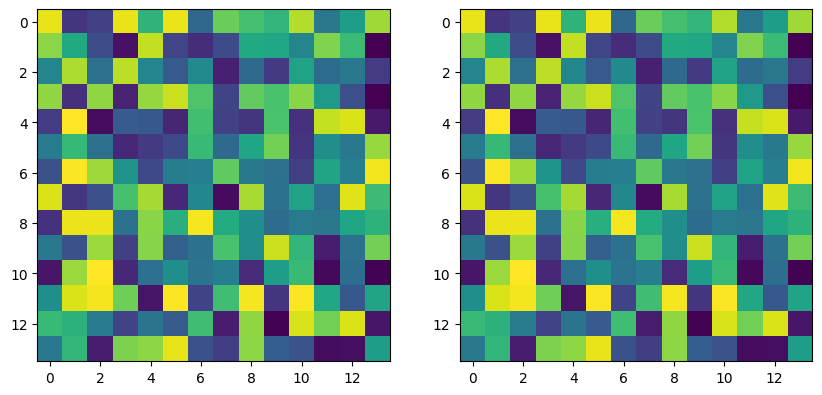

In [ ]:
import matplotlib.pyplot as plt

p = torch.rand((14,14))
print(p.shape)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(p)
axs[1].imshow(p)
# plt.tight_layout()
plt.show()

In [ ]:
fv1 = fv[1][1:].reshape([1, 768, 14, 14])
fv1.shape

torch.Size([1, 768, 14, 14])

In [ ]:
fv1 = torch.nn.functional.interpolate(input=fv1, mode='bilinear', scale_factor=2)
fv1.shape

torch.Size([1, 768, 28, 28])

In [ ]:
m1 = torch.cat([p.unsqueeze(0).unsqueeze(0), fv1], dim=1)
m1.shape

RuntimeError: ignored

In [ ]:
import torch
import torch.nn as nn

class Refiner(nn.Module):
  """ Refiner designed to upsample from a low level probability map into a pixel probability map  """

  def __init__(self):

    super(Refiner, self).__init__()

    self.conv = nn.Conv2d(in_channels=769 , out_channels=1, kernel_size=(3, 3), padding='same')
    self.relu = nn.ReLU()
    self.bn = nn.BatchNorm2d(1)
    self.W = nn.Linear(224, 224)
    self.sigmoid = nn.Sigmoid()
    self.W.bias.data.fill_(0.)

  def forward(self, p, fv):
    """
    Args:
      p:  low level probability map (14x14)
      fv[1]:  image tokens encoded at layer 1
      fv[2]:  image tokens encoded at layer 2
      fv[3]:  image tokens encoded at layer 3
      fv[4]:  image tokens encoded at layer 4
    """

    x = p.unsqueeze(0).unsqueeze(0)

    fv4 = fv[3][1:].reshape([1, 768, 14, 14])
    x = torch.cat([x, fv4], dim=1)
    x = self.conv(x)
    x = self.relu(x)
    x = self.bn(x)
    x = nn.functional.interpolate(input=x, mode='bilinear', scale_factor=2)

    fv3 = fv[2][1:].reshape([1, 768, 14, 14])
    fv3 = nn.functional.interpolate(input=fv3, mode='bilinear', scale_factor=2)
    x = torch.cat([x, fv3], dim=1)
    x = self.conv(x)
    x = self.relu(x)
    x = self.bn(x)
    x = nn.functional.interpolate(input=x, mode='bilinear', scale_factor=2)

    fv2 = fv[1][1:].reshape([1, 768, 14, 14])
    fv2 = nn.functional.interpolate(input=fv2, mode='bilinear', scale_factor=4)
    x = torch.cat([x, fv2], dim=1)
    x = self.conv(x)
    x = self.relu(x)
    x = self.bn(x)
    x = nn.functional.interpolate(input=x, mode='bilinear', scale_factor=2)

    fv1 = fv[0][1:].reshape([1, 768, 14, 14])
    fv1 = nn.functional.interpolate(input=fv1, mode='bilinear', scale_factor=8)
    x = torch.cat([x, fv1], dim=1)
    x = self.conv(x)
    x = self.relu(x)
    x = self.bn(x)
    x = nn.functional.interpolate(input=x, mode='bilinear', scale_factor=2)

    x = self.W(x)
    x = self.sigmoid(x)

    return x


In [ ]:
refiner = Refiner()


In [ ]:
p_map = refiner(p, fv).squeeze(0).squeeze(0).detach().numpy()
p_map.shape

(224, 224)

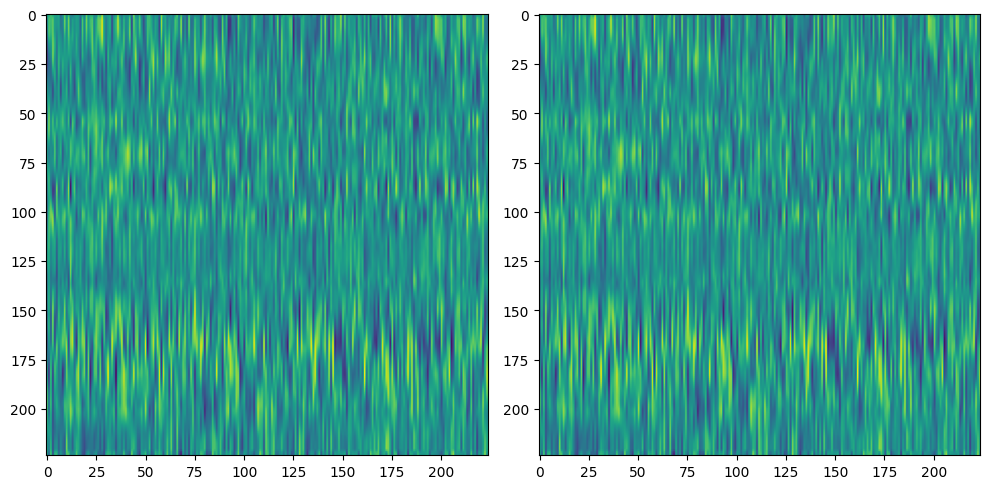

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(p_map)
axs[1].imshow(p_map)
plt.tight_layout()
plt.show()

# Fine-tuned Model

*Method*

### Define the Clip Model

### Cost function

### Optimizer

### Training and test step

### All together

## Experiments and discussion

## Comparison with other ours hipotesis and State-of-the-arts

## Ohter ideas / Proposals fo futher improvements

- *heat Map + Sam*:\
  pro:  non utilizza Yolo come object detector\
  cons: perde tutta la relazione testo immagine di clip\
  possible overcome: codificare la heatmap ed inserirla come input

  Risulati ottenuti:
  baseline con accuracy > 40%
  accuracy on average > 45% con qualche forma di ingegnerizzaione (e.g. frammentazione dell'imagine e lavoro sul testo)


## Conclusion

#References

1. "You Only Look Once: Unified, Real-Time Object Detection"
Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi
[2016]

2. "Learning transferable visual models from natural language supervision."
Radford, Alec, et al.
[2021]

3. "BLIP: Bootstrapping Language-Image Pre-training for
Unified Vision-Language Understanding and Generation"
Junnan Li Dongxu Li Caiming Xiong Steven Hoi
Salesforce Research
[2022]

4. "Segment Anything"
Kirillov, Mintun, Ravi et al.
Meta AI Research, FAIR
[2023]

5. "RISCLIP: Referring Image Segmentation Framework using CLIP"
Seoyeon Kim, Minguk Kang, Jaesik Park
[2023]

6. "Attention Is All You Need"
